In [1]:
import pandas as pd
from torch.utils.data import DataLoader

from data import DatasetWithConfounder
from models import HilbertSchmidtAE
from utils import embed_data, train
import argparse
import seaborn as sns
from utils import set_seeds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

from utils import knn_purity
from utils import entropy_batch_mixing

from os.path import join, isfile
from os import listdir
import numpy as np

from utils import configure_logging, load_data
from anndata import AnnData
import h5py
import scanpy as sc
import matplotlib

configure_logging()
set_seeds()
sns.set()

In [2]:
pancreas_study_cmap = matplotlib.cm.get_cmap("Dark2")
pancreas_study_cmap = [pancreas_study_cmap(0), pancreas_study_cmap(4), pancreas_study_cmap(7)]

cell_cmap = matplotlib.cm.get_cmap("tab20")

adata = load_data("pancreas", normalized=True)
pancreas_cell_cmap_map = {}
for i, cell_type in enumerate(adata.obs["cell_type"].unique()):
    pancreas_cell_cmap_map[cell_type] = cell_cmap(i)

In [3]:
pancreas_study_cmap_map = {}
for i, study in enumerate(adata.obs["study"].unique()):
    pancreas_study_cmap_map[study]= pancreas_study_cmap[i]

In [4]:
study_cmaps = {}
cell_type_cmaps = {}

In [5]:
study_cmaps["pancreas"] = pancreas_study_cmap_map
cell_type_cmaps["pancreas"] = pancreas_cell_cmap_map

In [6]:
adata = load_data("pbmc", normalized=True)

In [7]:
cell_cmap = matplotlib.cm.get_cmap("tab10_r")
pbmc_study_cmap = matplotlib.cm.get_cmap("Dark2_r")

pbmc_cell_cmap_map = {}
for i, cell_type in enumerate(adata.obs["cell_type"].unique()):
    pbmc_cell_cmap_map[cell_type] = cell_cmap(i)
    


pbmc_study_cmap_map = {}
for i, study in enumerate(adata.obs["study"].unique()):
    pbmc_study_cmap_map[study]= pbmc_study_cmap(i)
    
study_cmaps["pbmc"] = pbmc_study_cmap_map
cell_type_cmaps["pbmc"] = pbmc_cell_cmap_map

In [8]:
methods = ["mnnCorrect", "seurat", "harmony", "conos", "scvi", "desc", "hd-md"]

In [9]:
proper_names = ["MNN", "Seurat", "Harmony", "Conos", "scVI", "DESC", "HD-MD"]

In [10]:
from utils import silhouette_score
from tqdm import tqdm
from utils import ebm, silhouette, knn_purity

In [11]:
from utils import silhouette_score
from tqdm import tqdm
purities = [knn_purity(x, "pbmc", "study") for x in tqdm(methods)]

100%|██████████| 7/7 [20:22<00:00, 174.70s/it]


In [12]:
ebms = [ebm(x, "pbmc") for x in tqdm(methods)]

100%|██████████| 7/7 [06:30<00:00, 55.83s/it] 


In [13]:
silhouettes = [silhouette(x, "pbmc") for x in tqdm(methods)]

100%|██████████| 7/7 [44:17<00:00, 379.67s/it]


In [14]:
purities_pancreas = [knn_purity(x, "pancreas", "study") for x in tqdm(methods)]


100%|██████████| 7/7 [11:41<00:00, 100.15s/it]


In [15]:
ebms_pancreas = [ebm(x, "pancreas") for x in tqdm(methods)]
silhouettes_pancreas = [silhouette(x, "pancreas") for x in tqdm(methods)]

100%|██████████| 7/7 [37:25<00:00, 320.76s/it]


Text(0, 0.5, 'Silhouette Score')

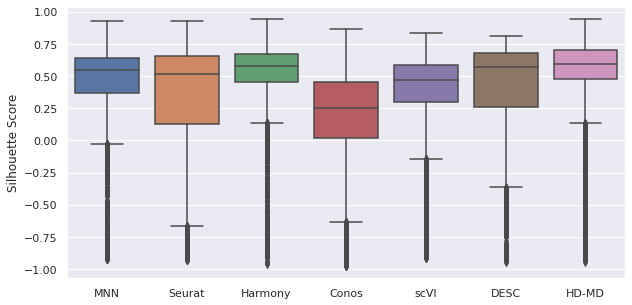

In [16]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(data=silhouettes_pancreas)
ax.set_xticklabels(proper_names)
ax.set_ylabel("Silhouette Score")

In [17]:
silhouette_pancreas_df = pd.DataFrame({ 
    "Score":np.concatenate(silhouettes_pancreas),
    "Method": np.concatenate([np.repeat(proper_names[i], len(silhouettes_pancreas[i])) for i in range(len(proper_names))]),
    "Dataset": np.repeat("Pancreas", len(np.concatenate(silhouettes_pancreas)))
})

In [18]:
import seaborn as sns

In [19]:
method = [np.repeat(proper_names[i], len(silhouettes[i])) for i in range(len(proper_names))]

In [20]:
silhouette_df = pd.DataFrame({ 
    "Score":np.concatenate(silhouettes),
    "Method": np.concatenate(method),
    "Dataset": np.repeat("PBMC", len(np.concatenate(silhouettes)))
})

In [21]:
total_silhouette_df = pd.concat([silhouette_pancreas_df, silhouette_df])

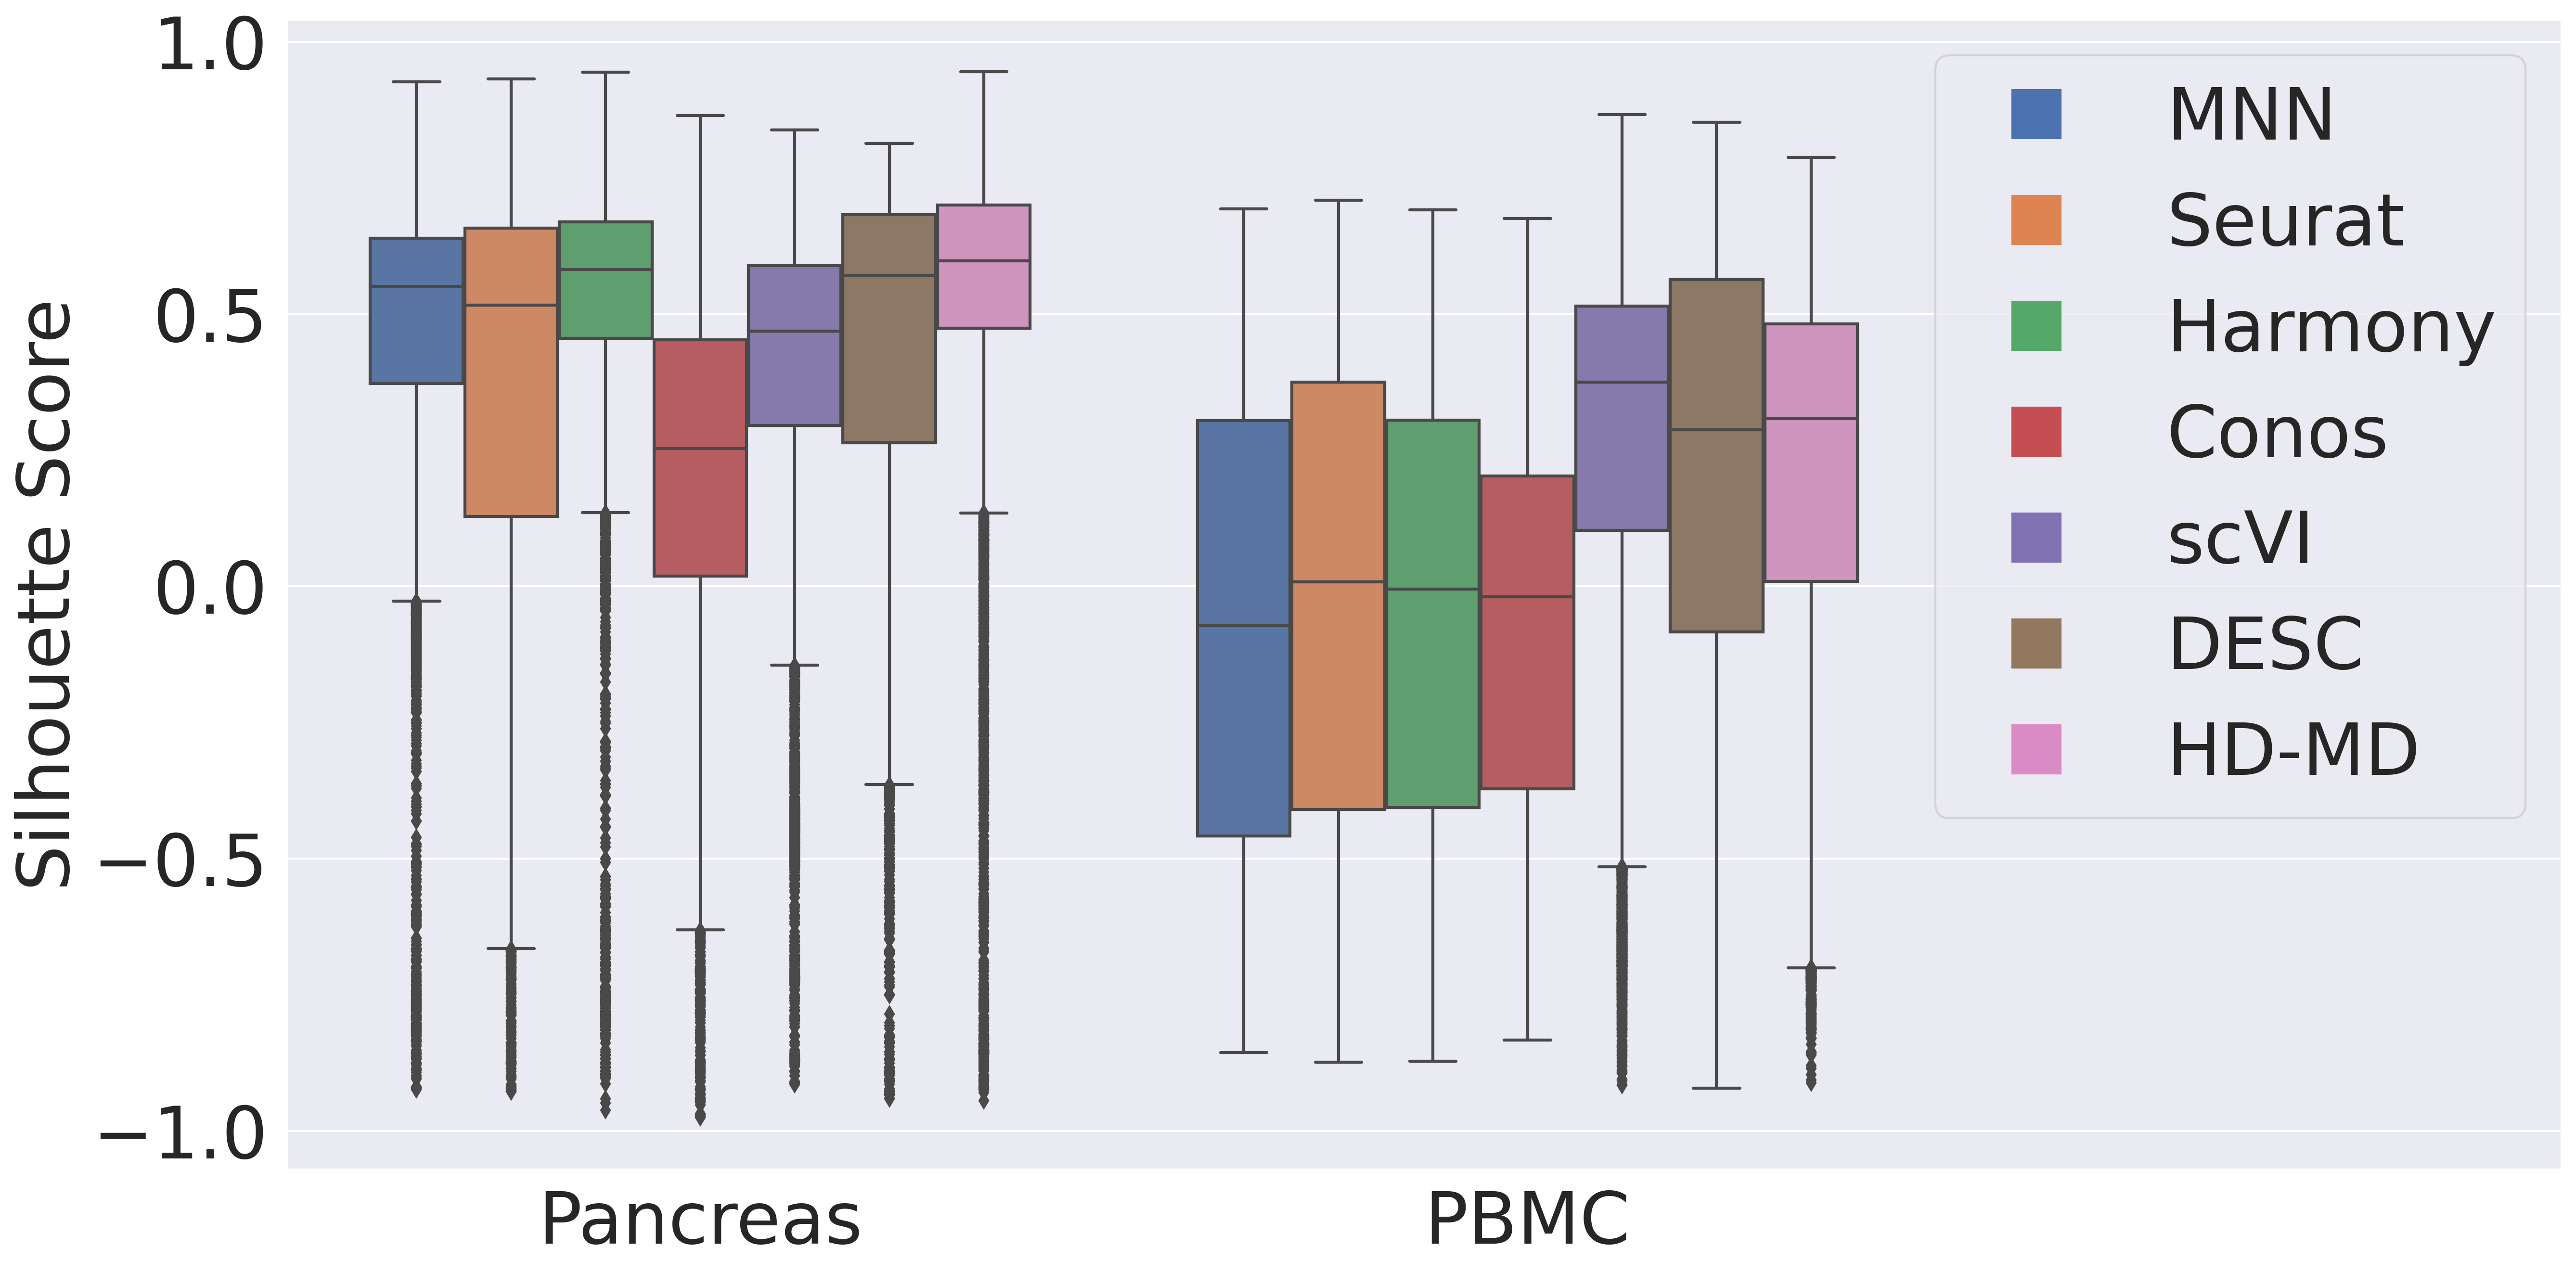

In [73]:
sns.set()
fontsize=36
plt.figure(figsize=(18,9), dpi=300)

ax = sns.boxplot(x="Dataset", y="Score", hue="Method", data=total_silhouette_df)
ax.set_ylabel("Silhouette Score", fontsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)
ax.xaxis.set_tick_params(labelsize=fontsize)
ax.set_xlabel("")
ax.set_xlim(-0.5, 2.25)
#plt.legend(fontsize=fontsize, loc='upper right')

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
colors = sns.color_palette()
handles = [f("s", colors[i]) for i in range(len(colors))]
legend = plt.legend(
    handles=handles,
    labels=proper_names,
    loc='upper right',
    fontsize=fontsize,
    markerscale=4
)
plt.tight_layout()

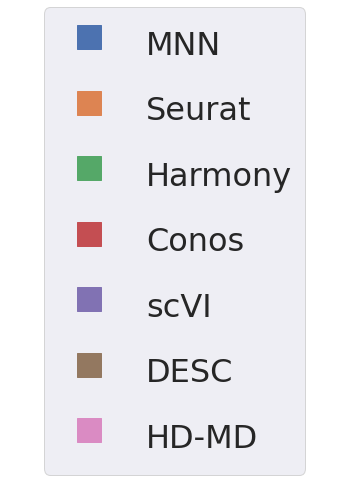

In [23]:
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
colors = sns.color_palette()
handles = [f("s", colors[i]) for i in range(len(colors))]
legend = plt.legend(
    handles=handles,
    labels=proper_names,
    loc='center',
    fontsize=32,
    handlelength=2,
    handleheight=2,
    markerscale=4
)
plt.gca().set_axis_off()
plt.show()

In [24]:
scores = np.concatenate([purities, ebms, [x+y for (x, y) in zip(ebms, purities)]])
score_names = np.concatenate([np.repeat("KNN Purity", len(purities)), np.repeat("EBM", len(purities)), np.repeat("Purity+EBM", len(purities))])

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler

purities_standardized = scaler().fit_transform(np.array(purities).reshape(-1, 1)).reshape(-1)
ebms_standardized = scaler().fit_transform(np.array(ebms).reshape(-1, 1)).reshape(-1)

In [26]:
purities_pancreas_standardized = scaler().fit_transform(np.array(purities_pancreas).reshape(-1, 1)).reshape(-1)
ebms_pancreas_standardized = scaler().fit_transform(np.array(ebms_pancreas).reshape(-1, 1)).reshape(-1)

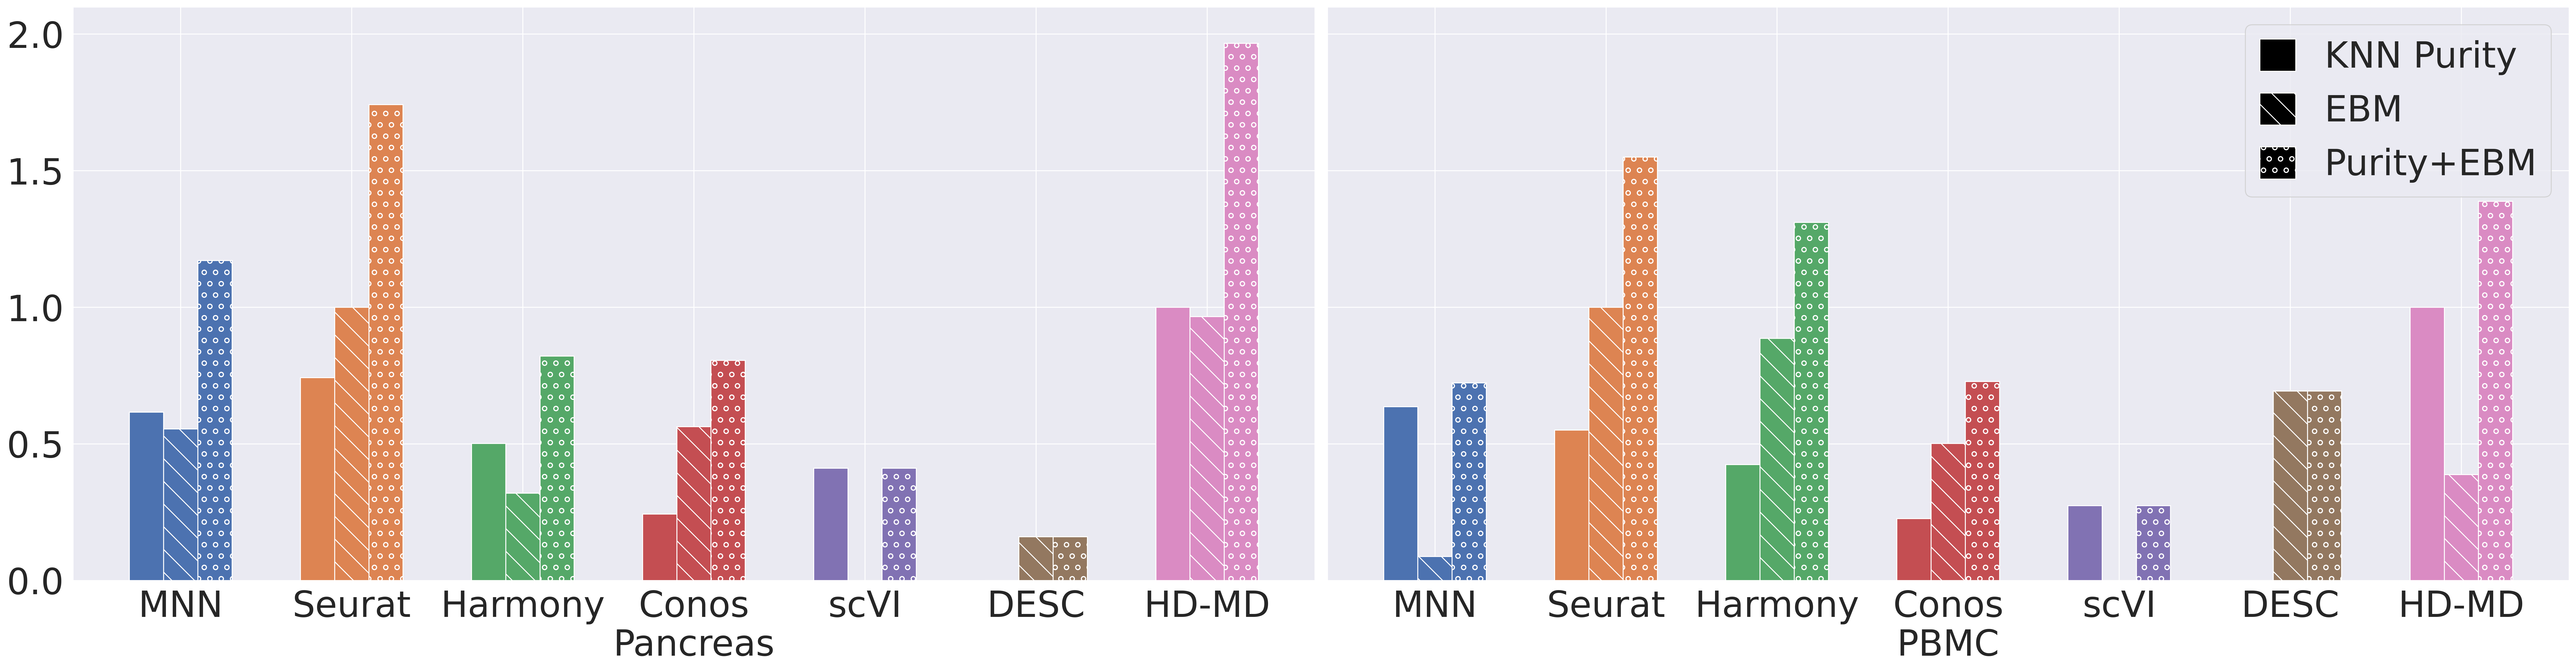

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(38,10), dpi=300)
fontsize=38

# set width of bar
barWidth = 0.2
 
# set height of bar
bars1 = purities_pancreas_standardized
bars2 = ebms_pancreas_standardized
bars3 = [x+y for (x, y) in zip(ebms_pancreas_standardized, purities_pancreas_standardized)]

#bars1 = purities_pancreas
#bars2 = ebms_pancreas
#bars3 = [x+y for (x, y) in zip(ebms_pancreas, purities_pancreas)]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

hatches = ['', '\\', 'o']
 
# Make the plot
ax1.bar(r1, bars1, color=list(sns.color_palette()), width=barWidth, edgecolor='white', label='KNN Purity', hatch=hatches[0])
ax1.bar(r2, bars2, color=list(sns.color_palette()), width=barWidth, edgecolor='white', label='EBM', hatch=hatches[1])
ax1.bar(r3, bars3, color=list(sns.color_palette()), width=barWidth, edgecolor='white', label='Purity+EBM', hatch=hatches[2])
 
# Add xticks on the middle of the group bars
ax1.set_xticks([r + barWidth for r in range(len(bars1))])
ax1.set_xticklabels(proper_names, fontsize=fontsize)
ax1.set_xlabel("Pancreas", fontsize=fontsize)
ax1.set_ylim(0, 2.1)

ax1.yaxis.set_tick_params(labelsize=fontsize)
 
# Create legend & Show graphic

# set height of bar
bars1 = purities_standardized
bars2 = ebms_standardized
bars3 = [x+y for (x, y) in zip(ebms_standardized, purities_standardized)]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
ax2.bar(r1, bars1, color=list(sns.color_palette()), width=barWidth, edgecolor='white', label='KNN Purity', hatch=hatches[0])
ax2.bar(r2, bars2, color=list(sns.color_palette()), width=barWidth, edgecolor='white', label='EBM', hatch=hatches[1])
ax2.bar(r3, bars3, color=list(sns.color_palette()), width=barWidth, edgecolor='white', label='Purity+EBM', hatch=hatches[2])
 
# Add xticks on the middle of the group bars
ax2.set_xticks([r + barWidth for r in range(len(bars1))])
ax2.set_xticklabels(proper_names, fontsize=fontsize)

ax2.yaxis.set_tick_params(labelsize=fontsize)
ax2.set_xlabel("PBMC", fontsize=fontsize)
ax2.set_ylim(0, 2.1)
ax2.set_yticklabels([])


from matplotlib.patches import Patch
metric_labels = ["KNN Purity", "EBM", "Purity+EBM"]
patches = [Patch(edgecolor=[1,1,1], facecolor=[0, 0, 0], label=metric_labels[i], hatch=hatches[i]) for i in range(len(hatches))]
 
# Create legend & Show graphic
#plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fontsize, handlelength=1.5, handleheight=1.5)
plt.legend(handles=patches, loc='upper right', fontsize=fontsize, handlelength=1, handleheight=1)

plt.tight_layout()
plt.show()